0.05 22.02
2008-01 88.17 5.73
2008-02 89.59 5.08
2008-03 88.94 5.4
2008-04 88.89 5.33
2008-05 90.88 4.23
2008-06 88.48 5.64
2008-07 89.7 5.22
2008-08 90.24 4.54
2008-09 89.83 4.83
2008-10 89.32 5.14
2008-11 86.85 6.52
2008-12 89.48 5.18
2009-11-12 00:00 25
2009-11-12 06:00 25
2009-11-12 09:00 23
2009-11-13 00:00 22
2009-11-15 03:00 25
2009-11-16 12:00 23
2009-11-28 18:00 23


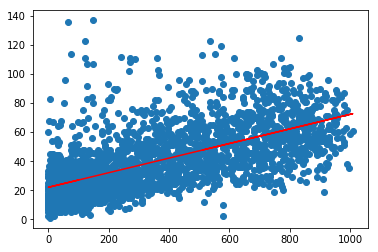

In [2]:
import pandas as pd
import datetime as dt
from scipy.odr import Model, Data, ODR
import matplotlib.pyplot as plt

# Define linear function to fit the data with
def linear_fn(b, x):
    b0, b1 = b
    return (b0*x) + b1


input_file = r'./Meteologica_vacante_ProgC_ProblemaDatos_20190602.txt'

data_obs =[]
data_pred = []
data_block = ""

# Read input file and save data into two arrays. One per each block (observations and predictions)
for line in open(input_file, 'r', encoding="utf8"):
    
    # Validate which data block we are reading
    if "observaciones" in line:
        data_block = "obs"
        continue
        
    if "predicciones" in line:
        data_block = "pred"
        continue
    
    # Get each value from line
    l = line.strip().split(" ")
    
    # Convert date in string to datetime object 
    date_time = dt.datetime.strptime(l[0] + " " + l[1], '%Y-%m-%d %H:%M')
    
    # Save data to appropiate array depending on which block we are reading
    if data_block == "obs":      
        production = float(l[2])
        wind_speed = float(l[3])

        # This is an own assumption:
        # Make sense that if there is wind but the production is 0, that's because the generator is stopped.
        # So I won't taking into account those values.
        # Unless there are other variables or conditions that aren't expressed in exercise.
        if (production == 0. and wind_speed > 0.):
            continue
            
        data_obs.append([date_time, production, wind_speed])
    else:
        wind_speed = float(l[2])

        data_pred.append([date_time, wind_speed])

# Create Dataframe with observations, set index with date_time and sort it
df_obs = pd.DataFrame(data_obs, columns=["date_time", "production", "wind_speed"])
df_obs = df_obs.set_index('date_time').sort_index()

# Create Dataframe with predictions, set index with date_time and sort it
df_preds = pd.DataFrame(data_pred, columns=["date_time", "wind_speed"])
df_preds = df_preds.set_index('date_time').sort_index()

# Get dependent (production) and independent variable (wind_speed)
x = df_obs["production"]
y = df_obs["wind_speed"]

# Fit linear model with ODR (Orthogonal distance regression)
# Because we have to use delta=1 in Deming regression, it becomes orthogonal regression
model = Model(linear_fn)
data = Data(x, y)
odr = ODR(data, model, beta0=[0,0])
out = odr.run()

# Get slope and intercept, with two decimal position
slope, intercept = [round(b, 2) for b in out.beta]

print(slope, intercept)

# Get predictions values for calculated slope and intercept
y_odr = linear_fn(out.beta, x)

# Calculate diff between observed and predicted productions. Will be used later to calculate EMA and EMC
df_obs["pred"] = y_odr
df_obs["diff_abs"] = (df_obs["production"] - df_obs["pred"]).abs()
df_obs["diff_sqr"] = (df_obs["diff_abs"]).pow(other=2)

# Group by month
g = df_obs.groupby(pd.Grouper(freq='M'))

# Calculate EMA and EMC with given formula
ema = (100 / g["production"].sum()) * g["diff_abs"].sum()
emc = ( (100 * g["diff_abs"].count()) / g["production"].sum()) * ((g["diff_abs"].sum() / g["diff_abs"].count()) ** (1/2))

# Round to 2 decimal position
ema = ema.round(2)
emc = emc.round(2)

# Concat Series into a DataFrame to print all calculations
df_e = pd.concat([ema, emc], axis=1)

# Change datetime index format to get only Year and Month
df_e.index = pd.to_datetime(df_e.index, format = '%Y-%m-%d').strftime('%Y-%m')

# Print EMA and EMC by month with desired formats
for index, row in df_e.iterrows():
    print(index, row[0], row[1])
    
# Make Predictions
y_pred = linear_fn(out.beta, df_preds["wind_speed"])
df_preds["pred"] = y_pred

# Change datetime index format --> '%Y-%m-%d %H:%M'
df_preds.index = pd.to_datetime(df_preds.index, format = '%Y-%m-%d %H:%M:%s').strftime('%Y-%m-%d %H:%M')

# Print Predictions
for index, row in df_preds.iterrows():
    print(index, int(row[1]))


# Validate results by plotting data + calculated linear function
plt.figure()

# Plot x,y variables as scatter plot
plt.scatter(x, y)

# Plot 
plt.plot(x, y_odr, '-r', label='y_odr')

plt.show()